In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from olist.seller import Seller
from olist.product import Product
from olist.data import Olist
from olist.order import Order
from ipywidgets import interact, IntSlider, Dropdown

In [3]:
olist = Olist()
data_olist = olist.get_data()

In [4]:
seller = Seller()
data_sellers = seller.get_training_data()

In [5]:
#data_sellers.head()

In [6]:
order = Order()
data_orders = order.get_training_data()

/home/lewagon/code/espiautlewagon/04-Decision-Science/XX-Presentation/olist/order.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders['order_purchase_timestamp'] = pd.to_datetime(delivered_orders['order_purchase_timestamp'])
/home/lewagon/code/espiautlewagon/04-Decision-Science/XX-Presentation/olist/order.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders['order_delivered_carrier_date'] = pd.to_datetime(delivered_orders['order_delivered_carrier_date'])
/home/lewagon/code

In [7]:
#data_orders.head()

In [8]:
# Load the geolocation data
data_geoloc = data_olist["geolocation"].drop_duplicates(subset="geolocation_state")
data_sellers = data_sellers.sort_values('profits')
data_items = data_olist["order_items"]

# Define constants
alpha = 3157.27
beta = 978.23
it_cost_init = 500_000


# Define the it_cost_update function
def it_cost_update(n_sellers, n_items):
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)


# Perform the analysis to get the result
def analysis(df):
    data_sellers_sorted = df.sort_values(by="profits")
    result = []
    profit_max = 0
    n_sellers_removed = 0

    for i in range(len(data_sellers_sorted)):
        n_sellers = i
        n_sellers_remaining = len(data_sellers_sorted) - i
        n_items_remaining = data_sellers_sorted.iloc[i:]["number_of_items"].sum()

        it_costs = it_cost_update(n_sellers_remaining, n_items_remaining)

        profit = data_sellers_sorted.iloc[i:]["profits"].sum() - it_costs

        if profit >= profit_max:
            profit_max = profit
            n_sellers_removed = i + 1
        result.append((n_sellers, profit))

    print(f"Max Profit: {profit_max} BRL")
    print(f"Removed Sellers: {n_sellers_removed}")

    return result, n_sellers_removed, profit_max

"""
# Interactive function to update the plot
def plot_update(n_removed, column_training, column_order_items):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))

    # Plot the profit data
    ax1 = axs[0, 0]
    ax1.plot(data_profit["n_sellers_removed"], data_profit["profit"], marker="o")
    ax1.axvline(
        x=n_removed, color="r", linestyle="--", label=f"Removed Sellers: {n_removed}"
    )
    ax1.set_title("Increasing profit by removing worst performing sellers")
    ax1.set_xlabel("Number of Removed Sellers")
    ax1.set_ylabel("Total Profit (BRL)")
    ax1.grid(True)
    ax1.legend()

    # Update the map
    sellers_worst = worst_sellers.head(n_removed)

    # Plot the most sold products by the removed sellers
    ax3 = axs[1, 0]
    seller_ids_removed = sellers_worst["seller_id"]
    order_items_removed = data_items[
        data_items["seller_id"].isin(seller_ids_removed)
    ]
    most_sold_products = order_items_removed[column_order_items].value_counts().head(10)
    most_sold_products.plot(kind="bar", ax=ax3, color="skyblue")
    ax3.set_title(f"Most Common {column_order_items} by Removed Sellers")
    ax3.set_xlabel(column_order_items)
    ax3.set_ylabel("Count")

    # Plot the chosen column data for removed sellers
    ax4 = axs[1, 1]
    column_data = data_sellers[data_sellers["seller_id"].isin(seller_ids_removed)][
        column_training
    ]  # .groupby('seller_id')[column_training].mean().astype(int)
    column_data.hist(ax=ax4, color="lightgreen", bins=20)
    ax4.set_title(f"Distribution of {column_training} from Removed Sellers")
    ax4.set_xlabel(f"{column_training} per seller")
    ax4.set_ylabel(f"{column_training} per seller")

    plt.tight_layout()
    plt.show()
"""

# Analyze data
result, n_sellers_removed, profit_max = analysis(data_sellers)
data_profit = pd.DataFrame(result, columns=["n_sellers_removed", "profit"])

# Prepare the geolocation data
data_sellers_sorted = data_sellers.sort_values(by="profits")
data_sellers_geoloc = pd.merge(
    data_sellers_sorted, data_geoloc, left_on="seller_state", right_on="geolocation_state"
)

# Sort sellers by increasing profits and select the worst performing sellers
worst_sellers = data_sellers_geoloc.sort_values(by="profits")

# Create a GeoDataFrame for the worst performing sellers
#gdf_worst_sellers = gpd.GeoDataFrame(
#    worst_sellers,
#    geometry=gpd.points_from_xy(
#        worst_sellers.geolocation_lng, worst_sellers.geolocation_lat
#    ),
#    crs="EPSG:4326",
#)
"""
# Create interactive widgets
columns_training = data_sellers.columns.tolist()
columns_order_items = data_items.columns.tolist()
interact(
    plot_update,
    n_removed=IntSlider(min=1, max=len(worst_sellers), step=1, value=1),
    column_training=Dropdown(
        options=columns_training,
        value="review_score",
        description="Training Data Column:",
    ),
    column_order_items=Dropdown(
        options=columns_order_items,
        value="product_id",
        description="Order Items Column:",
    ),
)
""";

Max Profit: 1070976.1160162983 BRL
Removed Sellers: 856


# CEO-Report -  How could Olist improve its profit?


**Assumptions:**

<u>Revenues:</u> sales fees - Rewview-costs - IT-costs

<u>Sales fees:</u> Olist takes a 10% cut on the product price (excl. freight) of each order

<u>Subscription fees:</u> Olist charges 80 BRL by month per seller

<u>Costs:</u>
Reputation costs estimated per order with bad reviews (<= 3 stars)

The IT costs formula is given by:
$ \text{IT-costs} = 3157.27 \times \sqrt{n_{\text{sellers}}} + 978.23 \times \sqrt{n_{\text{items}}}$
 

##  Olist can improve its profit by 50% up to 1 Mio. BRL by removing 3% of the sellers? 

### Exclude sellers

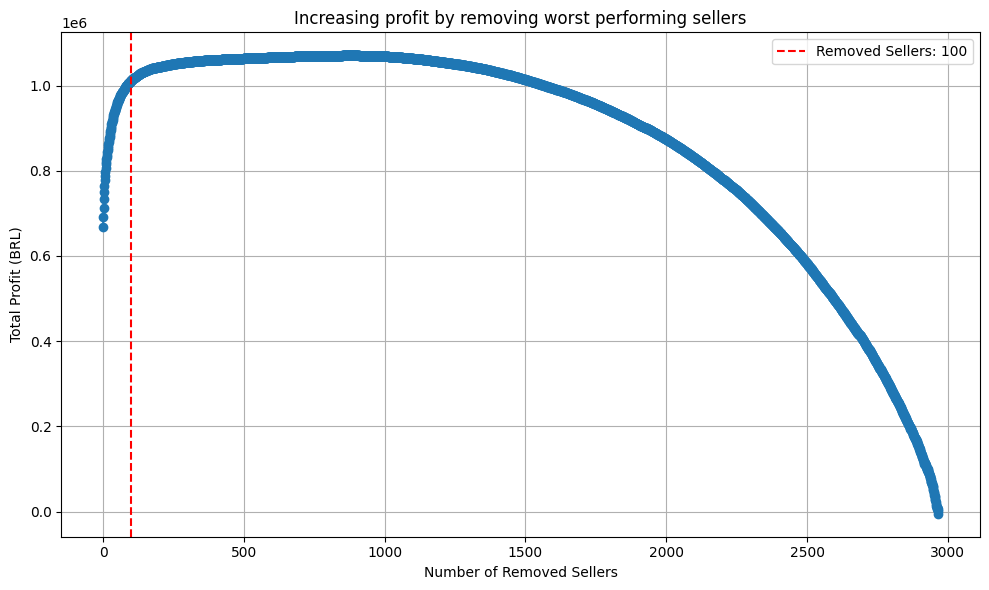

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(data_profit["n_sellers_removed"], data_profit["profit"], marker="o")
plt.axvline(x=100, color="r", linestyle="--", label=f"Removed Sellers: {100}")
plt.title("Increasing profit by removing worst performing sellers")
plt.xlabel("Number of Removed Sellers")
plt.ylabel("Total Profit (BRL)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Remove products

**Note:** *Focus on the red line and the sellers that we are removing, are they sharing some characteristics.*

**Show the green histogram.**

In [10]:
# Sort data_sellers by profits
data_sellers_sorted = data_sellers.sort_values(by="profits")

# Merge data_sellers_sorted with data_geoloc on seller_state and geolocation_state
data_sellers_geoloc = pd.merge(
    data_sellers_sorted, data_geoloc, left_on="seller_state", right_on="geolocation_state"
)

# Sort merged data by profits and select the worst 100 sellers
worst_sellers = data_sellers_geoloc.sort_values(by="profits").head(100)

# Extract seller_ids of the worst sellers
seller_ids_removed = worst_sellers["seller_id"]

# Filter data_items to include only those items from the worst sellers
order_items_removed = data_items[data_items["seller_id"].isin(seller_ids_removed)]

# Count the number of items per seller and get the top 10 sellers
most_sold_products = order_items_removed["seller_id"].value_counts().head(10)

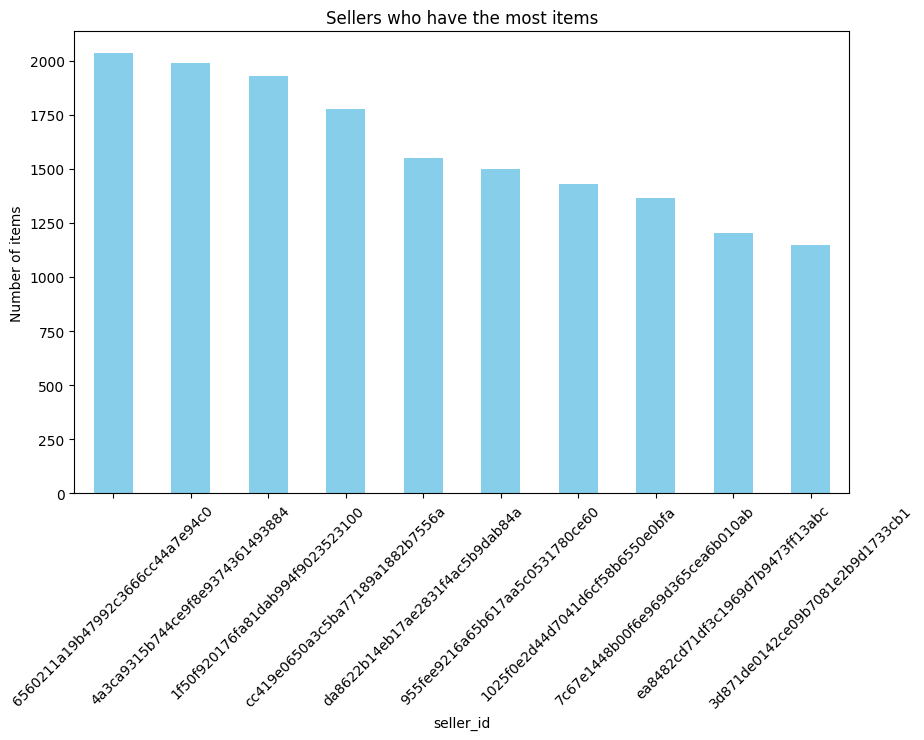

In [11]:
# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))
most_sold_products.plot(kind="bar", color="skyblue")
plt.title("Sellers who have the most items")
plt.xlabel("seller_id")
plt.ylabel("Number of items")
plt.xticks(rotation=45)
plt.show()

In [12]:
"""
data_sellers_sorted = data_sellers.sort_values(by="profits")
data_sellers_geoloc = pd.merge(
    data_sellers_sorted, data_geoloc, left_on="seller_state", right_on="geolocation_state"
)

worst_sellers = data_sellers_geoloc.sort_values(by="profits")
sellers_worst = worst_sellers.head(100)


seller_ids_removed = sellers_worst["seller_id"]
order_items_removed = data_items[data_items["seller_id"].isin(seller_ids_removed)]
most_sold_products = order_items_removed["seller_id"].value_counts().head(10)

histplot = most_sold_products.plot(kind="bar", color="skyblue")
histplot.set_title("Sellers who have the most items")
histplot.set_xlabel("seller_id")
histplot.set_ylabel("Number of items");
"""

'\ndata_sellers_sorted = data_sellers.sort_values(by="profits")\ndata_sellers_geoloc = pd.merge(\n    data_sellers_sorted, data_geoloc, left_on="seller_state", right_on="geolocation_state"\n)\n\nworst_sellers = data_sellers_geoloc.sort_values(by="profits")\nsellers_worst = worst_sellers.head(100)\n\n\nseller_ids_removed = sellers_worst["seller_id"]\norder_items_removed = data_items[data_items["seller_id"].isin(seller_ids_removed)]\nmost_sold_products = order_items_removed["seller_id"].value_counts().head(10)\n\nhistplot = most_sold_products.plot(kind="bar", color="skyblue")\nhistplot.set_title("Sellers who have the most items")\nhistplot.set_xlabel("seller_id")\nhistplot.set_ylabel("Number of items");\n'

### Exclude specific seller/customer pairs

**Note:** *Show the products, the number of items, the count of the products, the number of items per seller; to point out the high number of items per sellers.*

**Show the blue histogram.**

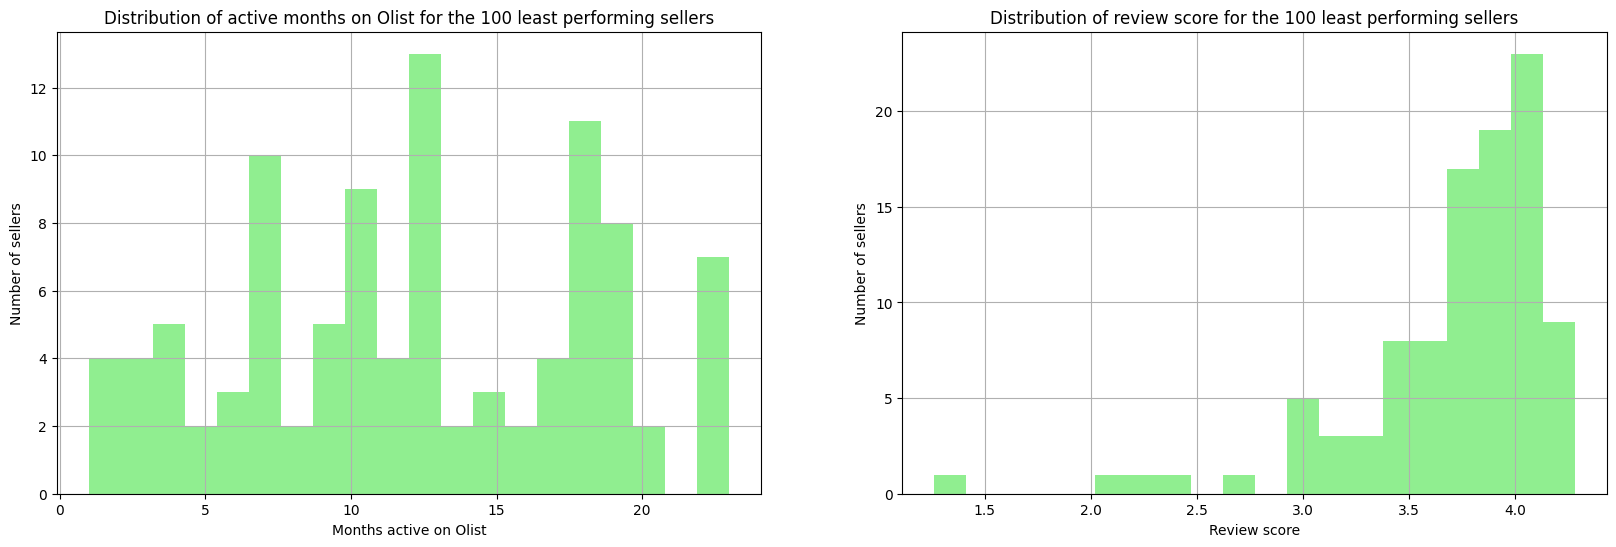

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

ax1 = axs[0]

# Plot the chosen column data for removed sellers
column_data = data_sellers[data_sellers["seller_id"].isin(seller_ids_removed)]["months_on_olist"]
histplot = column_data.hist(color="lightgreen", bins=20, ax=ax1)
histplot.set_title("Distribution of active months on Olist for the 100 least performing sellers")
histplot.set_xlabel("Months active on Olist")
histplot.set_ylabel("Number of sellers")

ax2 = axs[1]


# Plot the chosen column data for removed sellers
column_data = data_sellers[data_sellers["seller_id"].isin(seller_ids_removed)]["review_score"]
histplot = column_data.hist(color="lightgreen", bins=20, ax=ax2)
histplot.set_title("Distribution of review score for the 100 least performing sellers")
histplot.set_xlabel("Review score")
histplot.set_ylabel("Number of sellers");

#### Why?

In [14]:
"""
order_order_items = pd.DataFrame.merge(data['orders'], data['order_items'])
order_order_items_reviews = order_order_items.merge(data['order_reviews'][['review_id', 'review_score', 'order_id']], on='order_id')
order_order_items_reviews = order_order_items_reviews[['customer_id', 'order_id', 'seller_id', 'review_score', 'product_id']]
product = order_order_items_reviews.query("product_id == '422879e10f46682990de24d770e7f83d'")
other_products = order_order_items_reviews.query("product_id != '422879e10f46682990de24d770e7f83d'")
order_ids = product.query("review_score == 1")
order_ids.drop_duplicates(inplace=True)
#order_order_items_reviews = order_order_items_reviews.drop_duplicates()
#print(order_ids)

fig_1 = plt.figure(figsize=(10, 5))
sns.histplot(data=product, x='review_score', kde=True)

fig_2 = plt.figure(figsize=(10, 5))
sns.histplot(data=other_products, x='review_score', kde=True)
plt.show()
"""

'\norder_order_items = pd.DataFrame.merge(data[\'orders\'], data[\'order_items\'])\norder_order_items_reviews = order_order_items.merge(data[\'order_reviews\'][[\'review_id\', \'review_score\', \'order_id\']], on=\'order_id\')\norder_order_items_reviews = order_order_items_reviews[[\'customer_id\', \'order_id\', \'seller_id\', \'review_score\', \'product_id\']]\nproduct = order_order_items_reviews.query("product_id == \'422879e10f46682990de24d770e7f83d\'")\nother_products = order_order_items_reviews.query("product_id != \'422879e10f46682990de24d770e7f83d\'")\norder_ids = product.query("review_score == 1")\norder_ids.drop_duplicates(inplace=True)\n#order_order_items_reviews = order_order_items_reviews.drop_duplicates()\n#print(order_ids)\n\nfig_1 = plt.figure(figsize=(10, 5))\nsns.histplot(data=product, x=\'review_score\', kde=True)\n\nfig_2 = plt.figure(figsize=(10, 5))\nsns.histplot(data=other_products, x=\'review_score\', kde=True)\nplt.show()\n'